In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as scs
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
import json
import joblib
import pickle
import warnings
from tqdm.notebook import tqdm

from lightfm import LightFM
from lightfm.evaluation import auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder

warnings.filterwarnings("ignore")


C:\Users\vshir\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Загрузка данных
### Загружаем матрицы user-item

In [2]:
train_sparse = scs.load_npz('train_10k_sparse_matrix.npz')
train_sparse

<10000x88058 sparse matrix of type '<class 'numpy.float64'>'
	with 682428 stored elements in COOrdinate format>

In [3]:
test_sparse = scs.load_npz('test_10k_sparse_matrix.npz')
test_sparse

<10000x88058 sparse matrix of type '<class 'numpy.float64'>'
	with 170607 stored elements in COOrdinate format>

In [4]:
train = pd.read_csv('train_10k.csv')
test = pd.read_csv('test_10k.csv')
train.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,6fbf6970611d01e10aebeab374f461116155867e,SOPVPCY12A81C23555,1,Unlove You (Album Version),Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,fa8a8753518e6c2d3713990dc2a172ea17000b80,SOBSMEQ12AB018282F,1,Towards The Sun,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,c9fdf63587a7a963e383ea2f1b58d1014377caab,SONQEYS12AF72AABC9,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,e329cc2012d31242297d294fa0279b79a1bd5cc7,SOHTAXD12A8C141E75,1,Scratch Tail,Collide,Beats Antique,2008,electronic,United States,Oakland
4,2a9178398fa6377a340d5b9b6be87de32b4059a2,SOAWWJW12AB01814F5,2,Don't Haunt This Place,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto


### Создаем матрицу для item-features

In [5]:
test_zero = test.copy()
test_zero['play_count'] = 0

Чтобы избежать переобучения обнулим количество прослушиваний песен для теста и объединим тест и трейн.

In [6]:
test_zero.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,2005177b587bab57c6495e6282a59c1c485362e9,SODEIVI12A8C13266D,0,You Appearing,Saturdays = Youth,M83,2008,electronic,France,Antibes
1,a003bbe17ab7e7c8ed22cdedcb77006f1ffac951,SOQFKKT12A6701F129,0,The Old Homestead (Remastered Album Version),Hawks & Doves,Neil Young,1980,rock,Canada,Toronto
2,eb2d7cf1d1af8cfec816b8b9de265dc42713a6c3,SOZDGEW12A8C13E748,0,One,...And Justice For All,Metallica,1988,rock,United States,Los Angeles
3,d90c0e1ae7308b01b0ff64678ec812a5c8739760,SOZRIFX12A8C142691,0,Tú,Shakira MTV Unplugged,Shakira,1998,pop,Colombia,Barranquilla
4,d2b5bb931bc5e3fb907b7d4dd37a8c81144a1504,SOUCZKX12AB01826B4,0,Hustla Balla Gangsta Mack,Rich Boy,Rich Boy,2007,hiphop,United States,Mobile


In [7]:
data_10k = pd.concat([train, test_zero])

In [8]:
data_10k.shape

(853035, 10)

In [9]:
song_10k = data_10k[
    [
        "song_id",
        "play_count",
        "release",
        "artist_name",
        "year",
        "genre",
        "artist_country",
        "artist_city",
    ]
].drop_duplicates()
song_10k.head()


,song_id,play_count,release,artist_name,year,genre,artist_country,artist_city
0,SOPVPCY12A81C23555,1,Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,SOBSMEQ12AB018282F,1,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,SONQEYS12AF72AABC9,1,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,SOHTAXD12A8C141E75,1,Collide,Beats Antique,2008,electronic,United States,Oakland
4,SOAWWJW12AB01814F5,2,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto


In [10]:
song_10k = song_10k.groupby(
    [
        "song_id",
        "release",
        "artist_name",
        "year",
        "genre",
        "artist_country",
        "artist_city",
    ],
    as_index=False,
).agg({"play_count": "sum"})


In [11]:
with open('users_10k_id_for_sparse.txt', 'r') as fp:
    users_id_for_sparse = json.load(fp)
    
with open('songs_10k_id_for_sparse.txt', 'r') as fp:
    songs_id_for_sparse = json.load(fp)

In [12]:
def replace_user_id(x):
    return users_id_for_sparse[x]

def replace_song_id(x):
    return songs_id_for_sparse[x]

In [13]:
train['user_id'] = train.user_id.apply(replace_user_id)
train['song_id'] = train.song_id.apply(replace_song_id)

test['user_id'] = test.user_id.apply(replace_user_id)
test['song_id'] = test.song_id.apply(replace_song_id)

In [14]:
num_users, num_songs = train.user_id.nunique(), train.song_id.nunique()
num_users, num_songs

(10000, 81458)

Получим датасет с уникальными песнями и их фичами, включая целевую переменную - play_count.

In [15]:
song_10k['song_id'] = song_10k.song_id.apply(replace_song_id)
song_10k = song_10k.sort_values(by='song_id')
song_10k.head()

,song_id,release,artist_name,year,genre,artist_country,artist_city,play_count
0,0,The Room,Harold Budd,2000,ambient,United States,Los Angeles,0
1,1,Have Yourself A Tractors Christmas,The Tractors,1995,country,United States,Tulsa,1
2,2,At the Cut,Vic Chesnutt,2009,rock,United States,Jacksonville,0
3,3,20 Años,Alejandro Lerner,1998,latin,Argentina,Buenos Aires,3
4,4,Sefronia,Tim Buckley,1973,folk,United States,Washington,0


In [16]:
song_10k.shape

(88058, 8)

In [17]:
cat_cols = ['release', 'artist_name', 'year', 'genre', 'artist_country', 'artist_city']

In [18]:
pipe = Pipeline(
    [("enc", LeaveOneOutEncoder(cols=cat_cols)), ("scaler", StandardScaler())]
)


In [19]:
song_features = pipe.fit_transform(
    song_10k.drop("song_id", axis=1), song_10k.play_count
)
song_features.shape


(88058, 7)

In [20]:
items_features = scs.csr_matrix(song_features)
items_features

<88058x7 sparse matrix of type '<class 'numpy.float64'>'
	with 616406 stored elements in Compressed Sparse Row format>

## Обучаем LightFm

In [21]:
modelFM = LightFM(
    no_components=200,
    loss="warp",
    user_alpha=6e-5,
    item_alpha=2e-5,
    learning_rate=0.01,
    random_state=42,
    max_sampled=100,
)


In [22]:
epochs = 1
rounds = 10
for rounds in tqdm(range(rounds)):
    modelFM.fit_partial(
        train_sparse,
        sample_weight=train_sparse,
        epochs=epochs,
        num_threads=8,
        item_features=items_features,
        user_features=train_sparse,
    )


  0%|          | 0/10 [00:00<?, ?it/s]

Сохраним модель в pickle и сделаем предсказание для одного пользователя.

In [46]:
joblib.dump(modelFM, 'LightFM.pkl')

['LightFM.pkl']

In [47]:
LFM = joblib.load('LightFM.pkl')

In [48]:
%%time
modelFM.predict(
    900,
    np.arange(test_sparse.shape[1]),
    item_features=items_features,
    user_features=test_sparse,
)


Wall time: 146 ms


array([-50.11718 , -49.944122, -50.19552 , ..., -49.661564, -49.4535  ,
       -49.988396], dtype=float32)

In [49]:
scores = pd.Series(
    modelFM.predict(
        900,
        np.arange(test_sparse.shape[1]),
        item_features=items_features,
        user_features=test_sparse,
    )
)
scores.index = np.arange(test_sparse.shape[1])
scores = list(pd.Series(scores.sort_values(ascending=False).index))
scores[:10]


[52842, 41360, 24466, 79574, 24909, 11865, 35153, 70055, 21132, 68751]

### Делаем предсказание для 10к пользователей

In [28]:
pred = []
for row_id in tqdm(np.arange(test_sparse.shape[0])):
    score = pd.Series(
        modelFM.predict(
            int(row_id),
            np.arange(test_sparse.shape[1]),
            item_features=items_features,
            user_features=test_sparse,
            num_threads=8,
        )
    )
    score.index = np.arange(test_sparse.shape[1])
    score = list(pd.Series(score.sort_values(ascending=False).index))

    pred_items = score[:50]

    pred.append(pred_items)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
with open('LF_pred.pkl', 'wb') as f:
    pickle.dump(pred, f)

In [30]:
with open('LF_pred.pkl', 'rb') as f:
    pred_LF = pickle.load(f)

In [31]:
len(pred)

10000

## Оценка качества модели

In [32]:
true_relevant = []
for user, data in test[test.play_count >= 3].groupby('user_id'):
    true_relevant += [data.song_id.tolist()]

In [33]:
true_relevant = []
for user, data in test[test.play_count >= 3].groupby("user_id"):
    true_relevant += [data.song_id.tolist()]


def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
    for user, data in train.groupby("user_id"):
        user_preds = preds[user]
        new_preds[user] = user_preds[~np.in1d(user_preds, data.song_id)][:k]
    return new_preds


def get_random_preds(k=10):
    preds = np.tile(np.arange(num_songs), (num_users, 1))
    for i in range(num_users):
        rand_perm = np.random.permutation(num_songs)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    return preds


def get_toppop_preds(freq=10, k=10):
    mean_rating = train.groupby("song_id").play_count.mean()
    mean_rating = mean_rating[train.groupby("song_id").size() >= freq]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (num_users, 1))
    preds = remove_train_items(preds, k)
    return preds


def MAP_k(true, pred, k):
    m = 0
    num = min(len(true), len(pred))
    for tr, pr in zip(true, pred):
        if not tr:
            continue
        tr_in_pr = np.isin(pr[:k], tr)
        m += (tr_in_pr / np.arange(1, k + 1)).sum() / (
            1 / np.arange(1, len(tr) + 1)
        ).sum()
    m = m / num
    return m


In [39]:
ks = np.arange(1, 30)
random_preds = get_random_preds(k=ks[-1])
top_preds = get_toppop_preds(freq=10, k=ks[-1])

In [40]:
random_map_k = [MAP_k(true_relevant, random_preds, k=k) for k in ks]
top_map_k = [MAP_k(true_relevant, top_preds, k=k) for k in ks]
LFM_map_k = [MAP_k(true_relevant, pred, k=k) for k in ks]

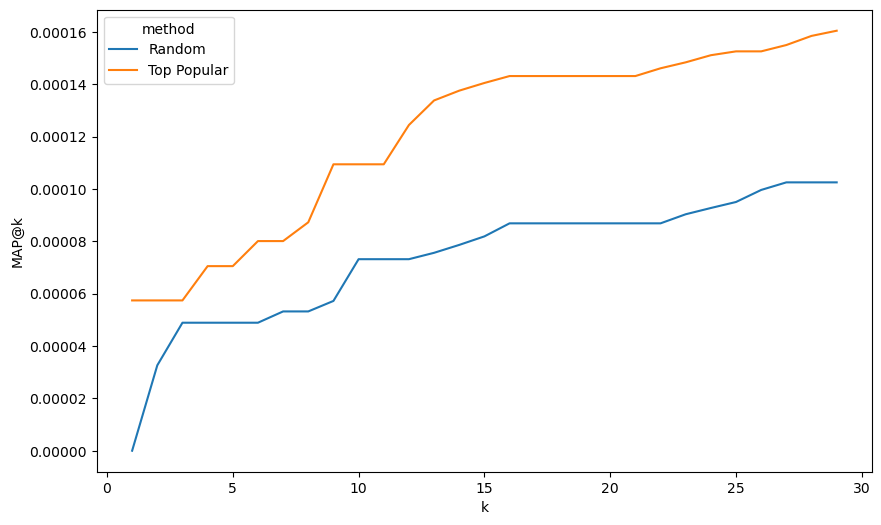

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

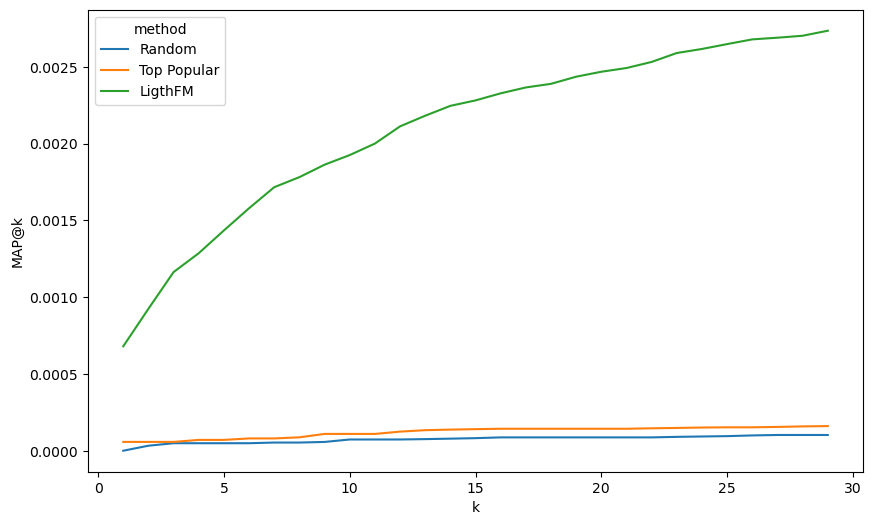

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')
plt.plot(ks, LFM_map_k, label='LigthFM')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

In [43]:
def AR_k(true, pred, k):

    if not true:
        return 0.0

    if len(pred) > k:
        pred = pred[:k]

    score = 0.0
    hits = 0.0

    for i, p in enumerate(pred):
        if p in true and p not in pred[:i]:
            hits += 1.0
            score += hits / (i + 1.0)

    return score / len(true)


def MAR_k(true, pred, k):

    return np.mean([AR_k(a, p, k) for a, p in zip(true, pred)])


In [44]:
random_map_k = [MAR_k(true_relevant, random_preds, k=k) for k in ks]
top_map_k = [MAR_k(true_relevant, top_preds, k=k) for k in ks]
LFM_map_k = [MAR_k(true_relevant, pred, k=k) for k in ks]

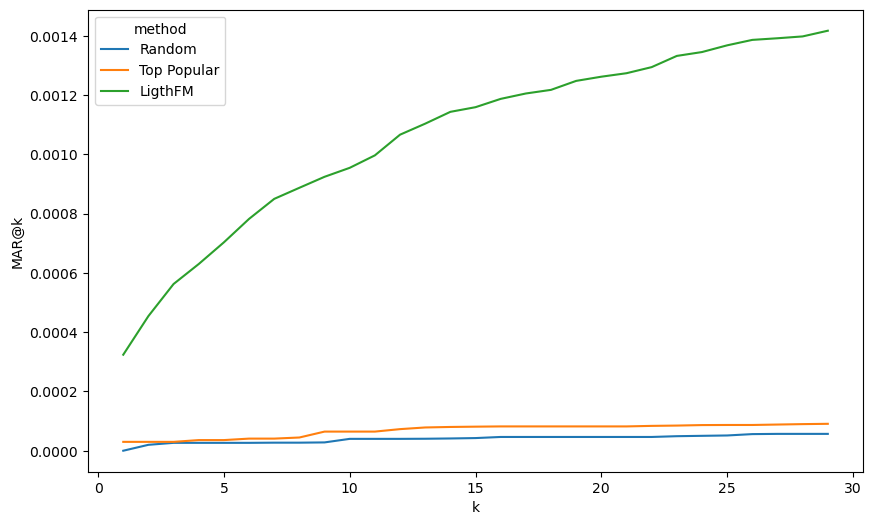

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')
plt.plot(ks, LFM_map_k, label='LigthFM')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAR@k')
plt.show()